In [3]:
# %%
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import json, random, math
from typing import Iterable, Tuple, List, Dict

# Config
TOKENIZED_FILE = '../Assignment_1/tokenizer/tokenized_gu_tokens.jsonl'
VAL_SIZE = 1000
TEST_SIZE = 1000
SEED = 42
random.seed(SEED)


In [4]:
# %%
def stream_sentences(path: str) -> Iterable[List[str]]:
    """Stream tokenized sentences from a huge JSONL file efficiently."""
    with open(path, 'r', encoding='utf-8') as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                token_groups = entry.get('tokens', [])
                if not token_groups:
                    continue
                for sent in token_groups:
                    if sent and isinstance(sent, list) and len(sent) > 0:
                        yield sent
            except Exception:
                continue

# Test stream
sample_stream = list(next(stream_sentences(TOKENIZED_FILE)) for _ in range(3))
print("✅ Sample sentences from stream:", sample_stream)


✅ Sample sentences from stream: [['આ', 'વીડિયો', 'જુઓ', ':', 'ઊંઝા', 'માર્કેટયાર્ડ', 'આજથી', '25', 'જુલાઈ', 'સુધી', 'બંધ'], ['આ', 'વીડિયો', 'જુઓ', ':', 'ઊંઝા', 'માર્કેટયાર્ડ', 'આજથી', '25', 'જુલાઈ', 'સુધી', 'બંધ'], ['આ', 'વીડિયો', 'જુઓ', ':', 'ઊંઝા', 'માર્કેટયાર્ડ', 'આજથી', '25', 'જુલાઈ', 'સુધી', 'બંધ']]


In [5]:
# %%
def create_splits(path: str, val_size=1000, test_size=1000, seed=SEED, max_sentences=1_000_000, log_every=10_000):
    """
    Create train/val/test splits using streaming & reservoir sampling.
    - Reads up to `max_sentences`
    - Skips blank sentences
    - Prints progress every `log_every`
    """
    val, test, train = [], [], []
    random.seed(seed)
    i = 0

    for sent in stream_sentences(path):
        if not sent or len(sent) == 0:
            continue  # skip empty sentences

        i += 1
        if i % log_every == 0:
            print(f"⏳ Processed {i:,} sentences...")

        # Limit to first `max_sentences`
        if i > max_sentences:
            print(f"🛑 Reached {max_sentences:,} sentences limit — stopping stream.")
            break

        # Reservoir sampling for val/test, rest go to train
        if len(val) < val_size:
            val.append(sent)
        elif random.random() < val_size / i:
            val[random.randrange(val_size)] = sent
        elif len(test) < test_size:
            test.append(sent)
        elif random.random() < test_size / i:
            test[random.randrange(test_size)] = sent
        else:
            train.append(sent)

    print(f"\n✅ Completed streaming {i:,} sentences.")
    print(f"📊 Train: {len(train):,}, Val: {len(val):,}, Test: {len(test):,}")
    return train, val, test


# Run the split creation
train, val, test = create_splits(TOKENIZED_FILE)


⏳ Processed 10,000 sentences...
⏳ Processed 20,000 sentences...
⏳ Processed 30,000 sentences...
⏳ Processed 40,000 sentences...
⏳ Processed 50,000 sentences...
⏳ Processed 60,000 sentences...
⏳ Processed 70,000 sentences...
⏳ Processed 80,000 sentences...
⏳ Processed 90,000 sentences...
⏳ Processed 100,000 sentences...
⏳ Processed 110,000 sentences...
⏳ Processed 120,000 sentences...
⏳ Processed 130,000 sentences...
⏳ Processed 140,000 sentences...
⏳ Processed 150,000 sentences...
⏳ Processed 160,000 sentences...
⏳ Processed 170,000 sentences...
⏳ Processed 180,000 sentences...
⏳ Processed 190,000 sentences...
⏳ Processed 200,000 sentences...
⏳ Processed 210,000 sentences...
⏳ Processed 220,000 sentences...
⏳ Processed 230,000 sentences...
⏳ Processed 240,000 sentences...
⏳ Processed 250,000 sentences...
⏳ Processed 260,000 sentences...
⏳ Processed 270,000 sentences...
⏳ Processed 280,000 sentences...
⏳ Processed 290,000 sentences...
⏳ Processed 300,000 sentences...
⏳ Processed 310,000

In [6]:
# %%
from collections import Counter

def ngrams_from_sentence(sent: List[str], n: int):
    """Yield n-grams from a given sentence."""
    for i in range(len(sent) - n + 1):
        yield tuple(sent[i:i+n])

def build_ngram_counts(sentences, max_n=4, log_every=10_000):
    """
    Build unigram → quadrigram counts.
    Adds progress logs every `log_every` sentences.
    """
    counters = {n: Counter() for n in range(1, max_n+1)}
    total_sents = len(sentences)
    print(f"🔨 Building up to {max_n}-gram counts for {total_sents:,} sentences...\n")

    for idx, sent in enumerate(sentences, start=1):
        for n in range(1, max_n+1):
            for ng in ngrams_from_sentence(sent, n):
                counters[n][ng] += 1

        if idx % log_every == 0:
            print(f"✅ Processed {idx:,}/{total_sents:,} sentences "
                  f"({(idx/total_sents)*100:.2f}%)")

    print("\n🎯 N-gram counting complete!\n")
    for n in range(1, max_n+1):
        print(f"🧩 {n}-gram unique count: {len(counters[n]):,}")

    return counters

# Run and show progress
counts = build_ngram_counts(train)


🔨 Building up to 4-gram counts for 985,443 sentences...

✅ Processed 10,000/985,443 sentences (1.01%)
✅ Processed 20,000/985,443 sentences (2.03%)
✅ Processed 30,000/985,443 sentences (3.04%)
✅ Processed 40,000/985,443 sentences (4.06%)
✅ Processed 50,000/985,443 sentences (5.07%)
✅ Processed 60,000/985,443 sentences (6.09%)
✅ Processed 70,000/985,443 sentences (7.10%)
✅ Processed 80,000/985,443 sentences (8.12%)
✅ Processed 90,000/985,443 sentences (9.13%)
✅ Processed 100,000/985,443 sentences (10.15%)
✅ Processed 110,000/985,443 sentences (11.16%)
✅ Processed 120,000/985,443 sentences (12.18%)
✅ Processed 130,000/985,443 sentences (13.19%)
✅ Processed 140,000/985,443 sentences (14.21%)
✅ Processed 150,000/985,443 sentences (15.22%)
✅ Processed 160,000/985,443 sentences (16.24%)
✅ Processed 170,000/985,443 sentences (17.25%)
✅ Processed 180,000/985,443 sentences (18.27%)
✅ Processed 190,000/985,443 sentences (19.28%)
✅ Processed 200,000/985,443 sentences (20.30%)
✅ Processed 210,000/9

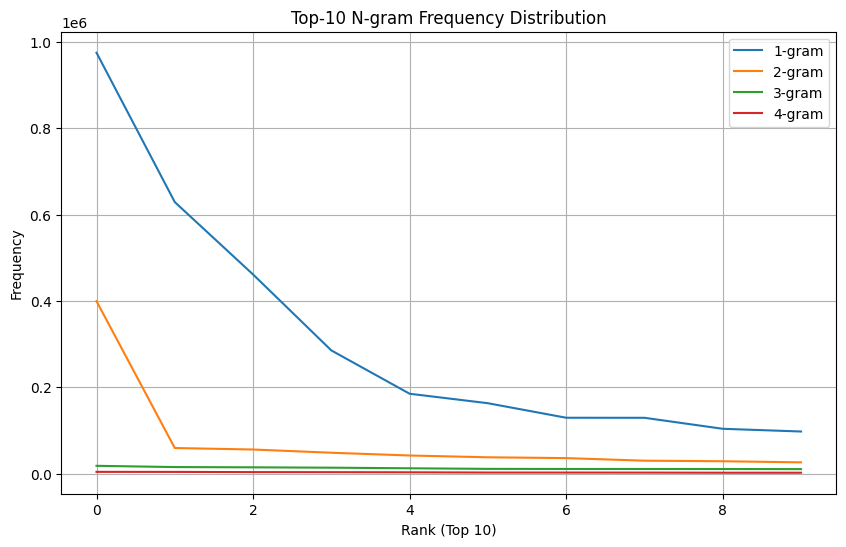

In [7]:
# %%
plt.figure(figsize=(10, 6))
for n in range(1, 5):
    top10 = counts[n].most_common(10)
    labels, values = zip(*top10)
    plt.plot(range(len(values)), values, label=f'{n}-gram')

plt.title("Top-10 N-gram Frequency Distribution")
plt.xlabel("Rank (Top 10)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# %%
from collections import Counter

def make_Nc(counter):
    """Compute frequency-of-frequency (Nc) counts."""
    return dict(Counter(counter.values()))

def compute_good_turing_adjusted_counts(counter, vocab_size, n):
    """Compute Good-Turing adjusted counts for n-grams."""
    Nc = make_Nc(counter)
    N = sum(counter.values())
    N1 = Nc.get(1, 0)
    P_unseen_total = (N1 / N) if N > 0 else 0.0
    adjusted_counts = {}

    for idx, (ng, c) in enumerate(counter.items(), start=1):
        Nc_c, Nc_cp1 = Nc.get(c, 0), Nc.get(c+1, 0)
        c_star = (c+1)*(Nc_cp1/Nc_c) if Nc_c > 0 else c
        adjusted_counts[ng] = c_star

        # Log progress every 50k n-grams
        if idx % 50_000 == 0:
            print(f"🔢 Processed {idx:,} {n}-grams...")

    print(f"\n✅ Finished Good-Turing for {n}-grams "
          f"— total unique={len(counter):,}, N1={N1:,}, P_unseen_total={P_unseen_total:.6f}")
    return adjusted_counts, P_unseen_total, Nc

# ---- Run for all n-grams ----
V = len({w for (w,), _ in counts[1].items()})
print(f"🧩 Vocabulary size (V): {V:,}\n")

gt_results = {}
for n in range(1, 5):
    print(f"🚀 Applying Good-Turing smoothing on {n}-grams...")
    adjusted_counts, P_unseen_total, Nc = compute_good_turing_adjusted_counts(counts[n], V, n)
    gt_results[n] = {
        'adjusted_counts': adjusted_counts,
        'P_unseen_total': P_unseen_total,
        'Nc': Nc,
    }
    print(f"📊 {n}-gram complete: P_unseen_total={P_unseen_total:.8f}, Nc[1]={Nc.get(1, 0):,}\n")


🧩 Vocabulary size (V): 554,784

🚀 Applying Good-Turing smoothing on 1-grams...
🔢 Processed 50,000 1-grams...
🔢 Processed 100,000 1-grams...
🔢 Processed 150,000 1-grams...
🔢 Processed 200,000 1-grams...
🔢 Processed 250,000 1-grams...
🔢 Processed 300,000 1-grams...
🔢 Processed 350,000 1-grams...
🔢 Processed 400,000 1-grams...
🔢 Processed 450,000 1-grams...
🔢 Processed 500,000 1-grams...
🔢 Processed 550,000 1-grams...

✅ Finished Good-Turing for 1-grams — total unique=554,784, N1=315,007, P_unseen_total=0.018669
📊 1-gram complete: P_unseen_total=0.01866915, Nc[1]=315,007

🚀 Applying Good-Turing smoothing on 2-grams...
🔢 Processed 50,000 2-grams...
🔢 Processed 100,000 2-grams...
🔢 Processed 150,000 2-grams...
🔢 Processed 200,000 2-grams...
🔢 Processed 250,000 2-grams...
🔢 Processed 300,000 2-grams...
🔢 Processed 350,000 2-grams...
🔢 Processed 400,000 2-grams...
🔢 Processed 450,000 2-grams...
🔢 Processed 500,000 2-grams...
🔢 Processed 550,000 2-grams...
🔢 Processed 600,000 2-grams...
🔢 Proc

In [9]:
from collections import Counter
def top_frequency_table(counter, top_k=100):
    Nc = Counter(counter.values())  # Nc[c] = number of types with count c
    max_c = max(Nc)  # highest count value seen
    rows = []
    for c in range(0, top_k):  # or iterate sorted counts
        nc = Nc.get(c, 0)
        # compute C* if possible
        if c == 0:
            cstar = None
        else:
            nc_c = Nc.get(c, 0)
            nc_cp1 = Nc.get(c+1, 0)
            if nc_c > 0:
                cstar = (c+1) * (nc_cp1 / nc_c)
            else:
                cstar = None  # need smoothing here
        rows.append((c, nc, cstar))
    return rows


In [10]:
import pandas as pd

# Choose which n-gram level you want to analyze (1 = unigram, 2 = bigram, etc.)
n = 1  # change to 2, 3, or 4 if you want others

# Get the counter for that n-gram
counter = counts[n]

# Generate the table
rows = top_frequency_table(counter, top_k=100)

# Convert to DataFrame for a clean table
df = pd.DataFrame(rows, columns=["Count (c)", "N(c)", "c* (Good–Turing)"])

# Display
print(f"\n📊 Top Frequency Table for {n}-grams:")
print(df.to_string(index=False))



📊 Top Frequency Table for 1-grams:
 Count (c)   N(c)  c* (Good–Turing)
         0      0               NaN
         1 315007          0.456098
         2  71837          1.419004
         3  33979          2.438565
         4  20715          3.341540
         5  13844          4.521237
         6  10432          5.276840
         7   7864          6.495422
         8   6385          7.477682
         9   5305          8.401508
        10   4457          9.427866
        11   3820         10.250262
        12   3263         11.701195
        13   2937         11.821587
        14   2480         14.237903
        15   2354         13.940527
        16   2051         15.300829
        17   1846         17.015168
        18   1745         17.148997
        19   1575         18.577778
        20   1463         18.818182
        21   1311         20.674294
        22   1232         21.506494
        23   1152         21.958333
        24   1054         24.667932
        25   1040         23

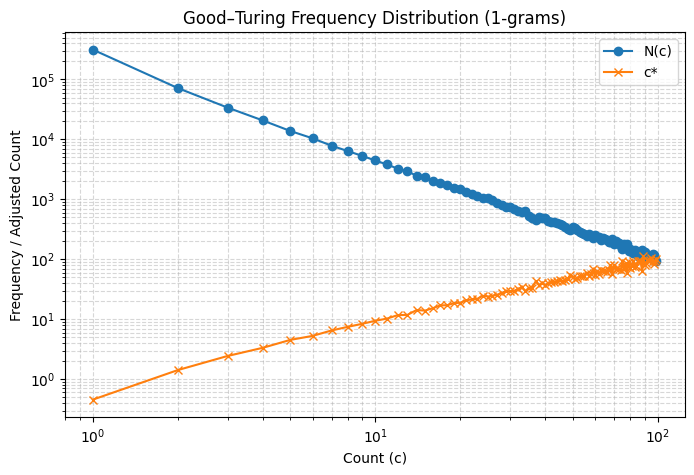

In [11]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = df[df["c* (Good–Turing)"].notna()]
plt.figure(figsize=(8,5))
plt.plot(df_plot["Count (c)"], df_plot["N(c)"], label="N(c)", marker='o')
plt.plot(df_plot["Count (c)"], df_plot["c* (Good–Turing)"], label="c*", marker='x')
plt.xscale("log")
plt.yscale("log")
plt.title("Good–Turing Frequency Distribution (1-grams)")
plt.xlabel("Count (c)")
plt.ylabel("Frequency / Adjusted Count")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


In [12]:
# %%
def ngram_prob(sentence, n, adjusted_counts, P_unseen_total, vocab_size):
    """Compute log-probability of a sentence under an n-gram model."""
    total_seen = len(adjusted_counts)
    unseen_space = max(vocab_size**n - total_seen, 1)
    p_unseen = P_unseen_total / unseen_space
    total_count = sum(adjusted_counts.values())
    logp = 0.0

    for idx, ng in enumerate(ngrams_from_sentence(sentence, n), start=1):
        p = adjusted_counts.get(ng, 0)
        p = (p / total_count) if p > 0 else p_unseen
        logp += math.log(p)
        if idx % 10 == 0:
            print(f"   🔹 {n}-gram[{idx}]={ng}, p={p:.6e}")

    return logp

# ---- Pick a sample and evaluate ----
sample_sentence = random.choice(val)
print(f"\n🧠 Sample sentence (first 15 tokens): {' '.join(sample_sentence[:15])} ...\n")

for n in range(1, 5):
    print(f"🧩 Evaluating {n}-gram probability...")
    logp = ngram_prob(sample_sentence, n,
                      gt_results[n]['adjusted_counts'],
                      gt_results[n]['P_unseen_total'],
                      V)
    print(f"✅ {n}-gram log-probability: {logp:.6f}\n")



🧠 Sample sentence (first 15 tokens): આ કારણેજ અંગો ઓછામાં ઓછી ઉર્જા વાપરીને શ્રેષ્ઠ કામ કરી શકે છે . કુદરતે આપણને ...

🧩 Evaluating 1-gram probability...
   🔹 1-gram[10]=('કરી',), p=1.866915e-02
   🔹 1-gram[20]=('બેચાર',), p=1.403785e-06
✅ 1-gram log-probability: -198.397366

🧩 Evaluating 2-gram probability...
   🔹 2-gram[10]=('કરી', 'શકે'), p=8.875006e-13
   🔹 2-gram[20]=('બેચાર', 'અંગો'), p=8.875006e-13
✅ 2-gram log-probability: -600.528667

🧩 Evaluating 3-gram probability...
   🔹 3-gram[10]=('કરી', 'શકે', 'છે'), p=1.035749e-03
   🔹 3-gram[20]=('બેચાર', 'અંગો', 'આપણા'), p=3.728564e-18
✅ 3-gram log-probability: -879.224930

🧩 Evaluating 4-gram probability...
   🔹 4-gram[10]=('કરી', 'શકે', 'છે', '.'), p=8.824440e-24
   🔹 4-gram[20]=('બેચાર', 'અંગો', 'આપણા', 'કંટ્રોલ'), p=8.824440e-24
✅ 4-gram log-probability: -1248.439449



   🔹 1-gram[10]=('કરી',), p=1.866915e-02
📘 1-gram: logp=-104.837, avg_logp=-6.9891, perplexity=1084.77
   🔹 2-gram[10]=('કરી', 'શકે'), p=8.875006e-13
📘 2-gram: logp=-310.284, avg_logp=-22.1631, perplexity=4220178943.19
   🔹 3-gram[10]=('કરી', 'શકે', 'છે'), p=1.035749e-03
📘 3-gram: logp=-413.581, avg_logp=-31.8139, perplexity=65555295834331.75
   🔹 4-gram[10]=('કરી', 'શકે', 'છે', '.'), p=8.824440e-24
📘 4-gram: logp=-558.341, avg_logp=-46.5284, perplexity=161073727425674575872.00


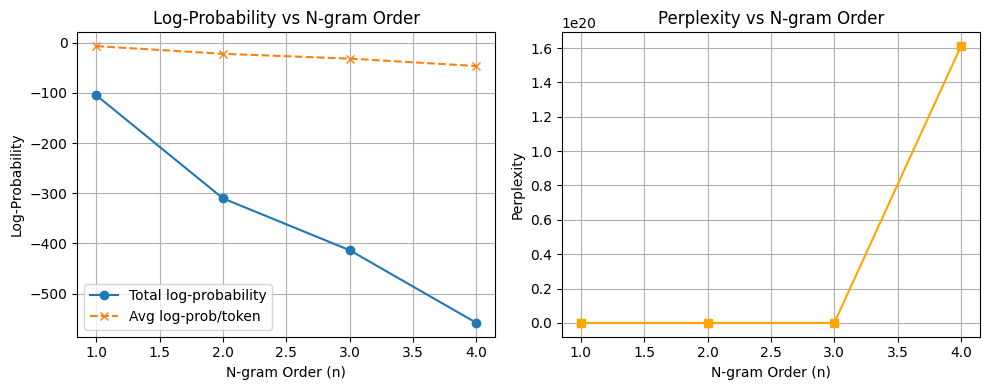

In [15]:
# %%
import numpy as np
import matplotlib.pyplot as plt

# Compute log-probs & perplexity for all models
results = []
for n in range(1, 5):
    logp = ngram_prob(sample_sentence, n,
                      gt_results[n]['adjusted_counts'],
                      gt_results[n]['P_unseen_total'],
                      V)
    num_ngrams = max(len(sample_sentence) - n + 1, 1)
    avg_logp = logp / num_ngrams
    ppl = np.exp(-avg_logp)
    results.append((n, logp, avg_logp, ppl))
    print(f"📘 {n}-gram: logp={logp:.3f}, avg_logp={avg_logp:.4f}, perplexity={ppl:.2f}")

# Convert to arrays for plotting
ns = [r[0] for r in results]
logps = [r[1] for r in results]
avg_logps = [r[2] for r in results]
ppls = [r[3] for r in results]

# Plot log-probability
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ns, logps, marker='o', label='Total log-probability')
plt.plot(ns, avg_logps, marker='x', linestyle='--', label='Avg log-prob/token')
plt.title("Log-Probability vs N-gram Order")
plt.xlabel("N-gram Order (n)")
plt.ylabel("Log-Probability")
plt.grid(True)
plt.legend()

# Plot perplexity
plt.subplot(1,2,2)
plt.plot(ns, ppls, marker='s', color='orange')
plt.title("Perplexity vs N-gram Order")
plt.xlabel("N-gram Order (n)")
plt.ylabel("Perplexity")
plt.grid(True)

plt.tight_layout()
plt.show()
